# Help Navigate Robot

### General Description

In this kernel, we need to analyze datas collected from sensors attached to a mobile robotic device driving over different floor surfaces. The goal is to predict the floor type based input sensor data.

Model:
Bidirectional LSTM (Long short-term memory), a type of RNN (Recurrent Neural Network) with Attention layer.

### Import Package

In [ ]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
import pytz

from sklearn.metrics import *
from sklearn.model_selection import *

import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

### Load Data
***X_train_new.csv*** - the input data, covering 10 sensor channels and 128 measurements per time series plus 
three ID columns: 

The 10 sensor channels are: 
* Orientation (X/Y/Z/W) - encode the current angles how the robot is oriented as a quaternion: 
* Angular Velocity (X/Y/Z) - describe the angle and speed of motion
* Linear Acceleration (X/Y/Z) - describe how the speed is changing at different times. 

ID Columns:
* row_id: The ID for this row
* series_id: ID number for the measurement series
* Foreign key to y_train/sample_submission. 
* measurement_number: Measurement number within the series. 

***X_test_new.csv***- similar with X_train, but split for testing purpose

***y_train_new.csv ***- the surfaces for training set
* series_id: ID number for the measurement series. 
group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies. 
* surface: the target for this competition. 

***y_test_new.csv ***- similar with y_train, but contains result from X_test_new.csv

***sample_submission.csv*** - a sample submission file I created myself with only 20 prediction slots

In [ ]:
X_train = pd.read_csv("../input/hw1-new/X_train_new.csv")
X_test = pd.read_csv("../input/hw1-new/X_test_new.csv")
y_train = pd.read_csv("../input/hw1-new/y_train_new.csv")
y_test_df = pd.read_csv("../input/hw1-new/y_test_new.csv")
submission = pd.read_csv("../input/hw1-new/sample_submission.csv")

In [ ]:
X_train.head()

Target distribution and values of features in a single time-series

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(y = y_train['surface'],
              data = y_train,
              order = y_train['surface'].value_counts().index)
plt.title('Target distribution')
plt.show()

In [ ]:
plt.figure(figsize=(26, 16))
single_serie = X_train.tail(128)
for i, col in enumerate(single_serie.columns[4:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(single_serie[col])
    plt.title(col)

## Prepare Data for the Network

### Input

### Step1: Check null value for training/ test set

In [ ]:
print ("Missing Data at Training")
totalt = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Count', '%'])
print(missing_data)

In [ ]:
totalt = X_test.isnull().sum().sort_values(ascending=False)
percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Count', '%'])
print ("Missing Data at Test")
print(missing_data)

### Step2: 
Data prep for X_train
* Drop first four columns that I wont use for neural network
* Convert quaternion date (orientation X/Y/Z/W) to euler angle
* Add ["pinch","roll","yaw"] to represent euler angle
* Remove Orientation X/Y/Z/W

In [ ]:
X_train.drop(['Unnamed: 0','row_id', "series_id", "measurement_number"], axis=1, inplace=True)

### Convert quarterion to euler angle
Orientation are provided in quaternions to prevent "gimbal lock" phenomenon. Gimbal lock occurs when the pitch angle approaches +/- 90 degrees

Therefore, rather using quaternion data as direct input, we will convert orientation X/Y/Z/W to into euler angle (roll, pinch, yaw) first with function below
https://computergraphics.stackexchange.com/questions/8195/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr

In [ ]:
def qaternion_to_euler(q_val):
    
    # q_val is in this format: [w, x, y, z]
    # quaternion is normalized
    
    w = q_val[0]
    x = q_val[1]
    y = q_val[2]
    z = q_val[3]
    
    t0 = 2 * (w * x + y * z)
    t1 = 1 - 2 * (x * x + y * y)
    
    t2 = 2 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    
    t3 = 2 * (w * z + x * y)
    t4 = 1 - 2 * (y * y + z * z)
    
    roll = np.arctan2(t0,t1)
    pitch = np.arcsin(t2)
    yaw = np.arctan2(t3,t4)
    return np.array([roll, pitch, yaw])

In [ ]:
cols = list(X_train.columns.values)
cols.remove('orientation_W')
cols.insert(3,'orientation_W')
X_train = X_train[cols]
quat_arr = np.array(X_train[['orientation_W','orientation_X','orientation_Y','orientation_Z']])
euler_arr = np.zeros([quat_arr.shape[0],3])
for n,arr in enumerate(quat_arr):
    euler_arr[n] = qaternion_to_euler(arr)

In [ ]:
X_train['roll'] = euler_arr[:,0]
X_train['pitch'] = euler_arr[:,1]
X_train['yaw'] = euler_arr[:,2]

In [ ]:
cols = list(X_train.columns.values)
cols.remove('orientation_X')
cols.remove('orientation_Y')
cols.remove('orientation_Z')
cols.remove('orientation_W')
X_train = X_train[cols]

### Draw plot to observe the pattern for each feature for a single serie in X_train

In [ ]:
plt.figure(figsize=(26, 16))
single_train_serie = X_train.tail(128)

for i, col in enumerate(single_train_serie.columns):
    plt.subplot(3, 4, i + 1)
    plt.plot(single_train_serie[col])
    plt.title(col)

In [ ]:
X_train = X_train.values.reshape((3790, 128, 9))

### Step3: Follow same data prep process for X_test

In [ ]:
X_test.drop(['Unnamed: 0','row_id', "series_id", "measurement_number"], axis=1, inplace=True)
X_test.head()

In [ ]:
cols_test = list(X_test.columns.values)
cols_test.remove('orientation_W')
cols_test.insert(3,'orientation_W')
X_test = X_test[cols_test]
X_test.head()
quat_arr_test = np.array(X_test[['orientation_W','orientation_X','orientation_Y','orientation_Z']])
euler_arr_test = np.zeros([quat_arr_test.shape[0],3])
for n,arr in enumerate(quat_arr_test):
    euler_arr_test[n] = qaternion_to_euler(arr)

In [ ]:
X_test['roll'] = euler_arr_test[:,0]
X_test['pitch'] = euler_arr_test[:,1]
X_test['yaw'] = euler_arr_test[:,2]
X_test.head()

cols_test = list(X_test.columns.values)
cols_test.remove('orientation_X')
cols_test.remove('orientation_Y')
cols_test.remove('orientation_Z')
cols_test.remove('orientation_W')
X_test = X_test[cols_test]
#print(X_test)

In [ ]:
X_test.head()

### Draw plot to observe the pattern for each feature for a single serie in X_test

In [ ]:
plt.figure(figsize=(26, 16))
single_test_serie = X_test.tail(128)

for i, col in enumerate(single_test_serie.columns):
    plt.subplot(3, 4, i + 1)
    plt.plot(single_test_serie[col])
    plt.title(col)

### Should I use fourier analysis?
In the plots above, there are indeed some distictive patterns in "roll" and "angular velocity". However, after reading this post, https://www.kaggle.com/trohwer64/simple-fourier-analysis, I decide not to pursue this route due to the fact that the "noise" in each surface class is very high. The average of the classes are distinct, but that does not help that much in practise, as the the deviation from the mean in the individual frequencies is not independent.

In [ ]:
X_test = X_test.values.reshape((20, 128, 9))

### Ouput

We encode our targets

In [ ]:
encode_dic = {'fine_concrete': 0, 
              'concrete': 1, 
              'soft_tiles': 2, 
              'tiled': 3, 
              'soft_pvc': 4,
              'hard_tiles_large_space': 5, 
              'carpet': 6, 
              'hard_tiles': 7, 
              'wood': 8}

In [ ]:
decode_dic = {0: 'fine_concrete',
              1: 'concrete',
              2: 'soft_tiles',
              3: 'tiled',
              4: 'soft_pvc',
              5: 'hard_tiles_large_space',
              6: 'carpet',
              7: 'hard_tiles',
              8: 'wood'}

In [ ]:
y_train = y_train['surface'].map(encode_dic).astype(int)

## Modeling

###  Attention Layer
Attention is a mechanism combined in the RNN allowing it to focus on certain parts of the input sequence when predicting a certain part of the output sequence, enabling easier learning and of higher quality. Combination of attention mechanisms enabled improved performance in many tasks making it an integral part of modern RNN networks.

In [ ]:

class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],), initializer=self.init, name='{}_W'.format(self.name), regularizer=self.W_regularizer, constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],), initializer='zero', name='{}_b'.format(self.name), regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None: a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


### Model

I choose to use RNN over CNN because RNNs, are suitable for Classification prediction problems. In multiple RNN models, I choose to use LSTM, because it overcomes the problems of training a RNN (such as vanishing gradients) and it has been widely used.

I use two hidden layer to improve the performance as three hidden layers result in no significant performance increase, yet takes much longer to execute

Drop out rate is 0.5

CuDNNLSTM is a *fast* LSTM implementation backed by *CuDNN*. It significantly improved the processing speed.
Normal LSTM complete a Epoch ~10s
CuDNNLSTM takes <1s

Particularly, using Bidirectional LSTM because the output is generated from both the past and future context. Therefore it is a more suitable model for prediction problem. Bidirectional LSTM has two networks, one access information in forward direction and another access in the reverse direction. 

Using sigmoid activation function performs better than relu

Units: Positive integer, dimensionality of the output space. I choose 256 and 128 for first and second hidden layer respectively


In [ ]:
def make_model():
    inp = Input(shape=(128, 9))
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(inp)
    x = Dropout(0.5)(x)
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Attention(128)(x)
    x = Dense(9, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### $k$-Folds
Use k-fold for cross validation to calculate accuracy. K = 5. I decide to choose a relatively larger batch size (128) with larger epochs size (1000) as well to fit the model better. I choose 1000 as epochs size because I notice there's no significant performance improvement after 1000 iteration

In [ ]:
def k_folds(X, y, X_test, k):
    folds = list(StratifiedKFold(n_splits=k).split(X, y))
    y_test_pred = np.zeros((X_test.shape[0], 9))
    y_train_pred = np.zeros((X.shape[0]))
    
    for i, (train_idx, val_idx) in  enumerate(folds):
        print(f"Fold {i+1}")
        model = make_model()
        model.fit(X[train_idx], y[train_idx], batch_size=128, epochs=1000, 
                  validation_data=[X[val_idx], y[val_idx]], verbose=1)
        
        pred_val = np.argmax(model.predict(X[val_idx]), axis=1)
        #score = accuracy_score(pred_val, y[val_idx])
        #y_oof[val_idx] = pred_val
        score = accuracy_score(y[val_idx], pred_val)
        y_train_pred[val_idx] = pred_val
        
        print(f'Scored {score:.3f} on validation data')
        
        y_test_pred += model.predict(X_test)
        
    return y_train_pred, y_test_pred                                                                         

### Training model and prediction
Estimated run time: ~2.5hr, ~30min per fold

In [ ]:
y_train_pred, y_test_pred = k_folds(X_train, y_train, X_test, k=5)

### Compare y_test prediction with the real label

In [ ]:
y_test_df.head()
y_test_ans = y_test_df['surface'].map(encode_dic).astype(int)

In [ ]:
y_test_pred = np.argmax(y_test_pred, axis=1)
print(y_test_pred)

In [ ]:
y_test_score = str(np.around(accuracy_score(y_test_ans, y_test_pred), decimals= 2))
print(f'y_test_new Prediction accuracy is '+ y_test_score)

### (Optional) Confusion Matrix Creation

In [ ]:
def create_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

### Confusion Matrix for y_train

In [ ]:
create_confusion_matrix(y_train, y_train_pred, encode_dic.keys())

### Confusion Matrix for y_test

In [ ]:
create_confusion_matrix(y_test_ans, y_test_pred, encode_dic.keys())

### Submission

In [ ]:
submission['surface'] = y_test_pred
submission['surface'] = submission['surface'].map(decode_dic)

In [ ]:
submission.head()

In [ ]:
tz_NY = pytz.timezone('America/New_York') 
now = datetime.now(tz_NY)
time = now.strftime("%m%d%H%M")

filename = 'submission_'+time+'_'+y_test_score+'.csv'
submission.to_csv(filename, index=False)

### Highest CV achieved: 0.796
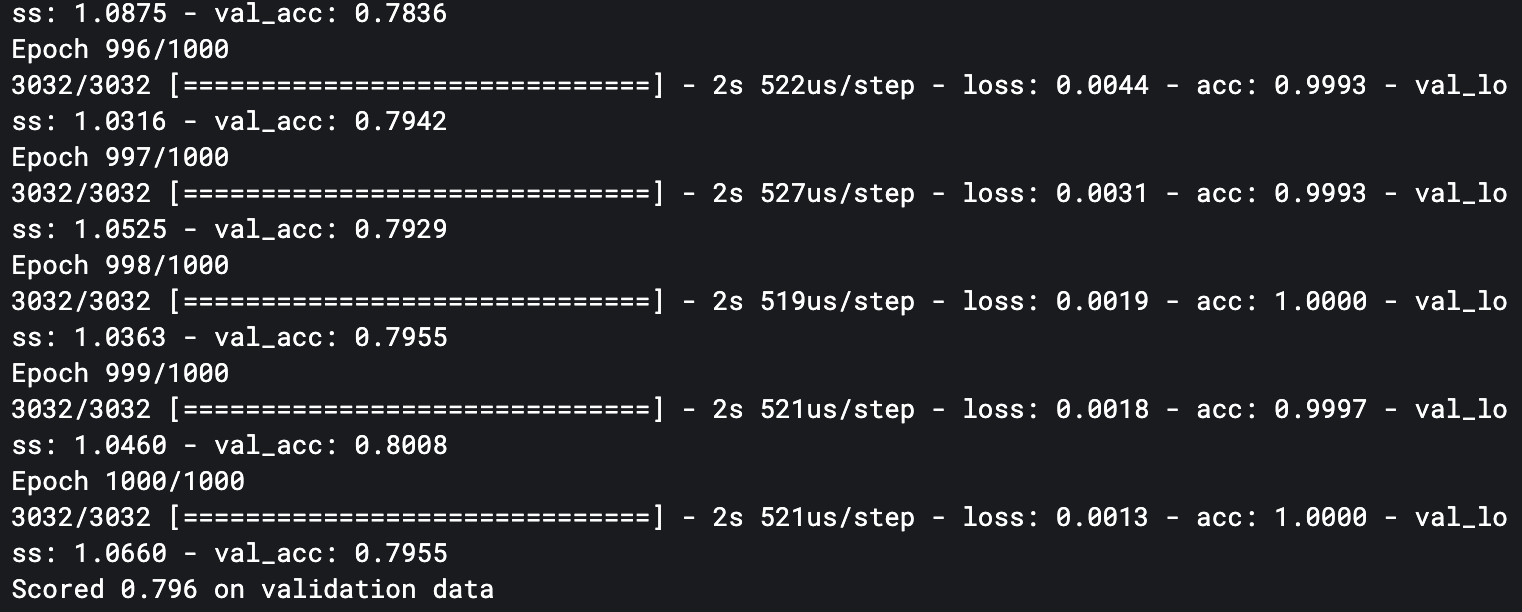

### Best y_test result: 0.8
    series_id,surface
    0,hard_tiles_large_space
    1,concrete
    2,soft_pvc
    3,tiled
    4,hard_tiles_large_space
    5,tiled
    6,wood
    7,wood
    8,concrete
    9,tiled
    10,soft_pvc
    11,hard_tiles_large_space
    12,tiled
    13,wood
    14,tiled
    15,tiled
    16,wood
    17,hard_tiles_large_space
    18,tiled
    19,soft_pvc

Special thanks to 
* https://www.kaggle.com/theoviel/deep-learning-starter
* https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook
* https://www.kaggle.com/skondrash/nn-lstm-fft-features?scriptVersionId=12804485
* https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution/notebook